In [107]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from shapely import wkt
import pickle
import json
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Convert Table 4 to Figure
I want to visualize at which facilities the different traders are active.

In [74]:
file = "Data/OurData2.xlsx"
nodes_df = pd.read_excel(file, sheet_name="Nodes", skiprows=1)
shipper_df = pd.read_excel(file, sheet_name="Traders")

# We include this to merge with the shipper df later
nodes_df["Name lowercase"] = nodes_df["Name"].str.lower()
nodes_df.set_index("Name lowercase", inplace = True)

In [75]:
trader_abbreviated_names = ["Shell", "Aker BP", "ConocoPhillips", "Equinor", "Lundin Energy", "Neptune Energy", "Var Energi", "Wintershall DEA"]

def get_short_name(trader):
    return [t for t in trader_abbreviated_names if t in trader][0]

# Constants
colors = ["#A7C7E7", "#F9C6B0", "#B5EAD7", "#CDB4DB", "#FFECB3", 
  "#F7A8A8", "#A0D6B4", "#D8BFD8", "#D8BFD8"]

markets = ["Zeebrugge", "Poland", "Emden", "Dornum", "Dunkerque", "Teesside", "Easington", "St.fergus"]

# Extract unique traders
traders = sorted(trader_abbreviated_names)

# Define a color mapping for traders
colors_dict = {trader: color for trader, color in zip(traders, colors)}

# Map colors based on trader names (ignoring "Bought" or "Sold")
bar_colors = [colors_dict[trader] for trader in traders]

In [76]:
nodes_geo_df = gpd.GeoDataFrame(nodes_df, geometry=nodes_df[["X_coordinate", "Y_coordinate"]].apply(Point, axis=1)).set_crs(4326).to_crs(32631)

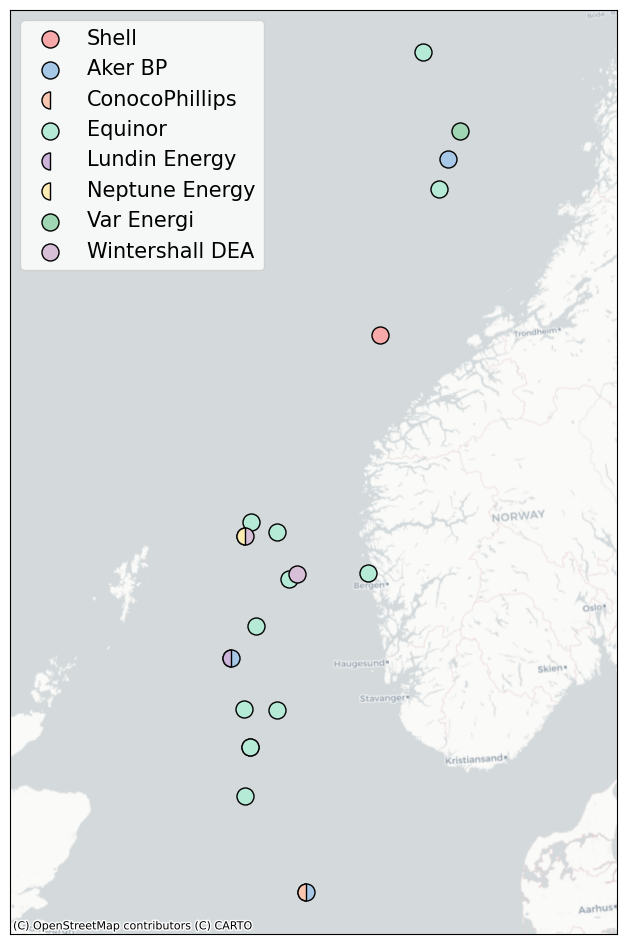

In [77]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
          "#9467bd", "#17becf", "#bcbd22", "#7f7f7f"]

original_traders = shipper_df.columns
trader_dict = {}
for i, trader in enumerate(original_traders):
    facilities_of_trader = shipper_df[trader].str.lower()[:12].dropna().values
    if trader in ["ConocoPhillips Skandinavia AS", "Lundin Energy Norway AS", "Neptune Energy Norge AS"]:
        marker = MarkerStyle("o", fillstyle="left")
        z = 100
    else:
        z = 1
        marker = MarkerStyle("o")

    short_name_trader = get_short_name(trader)
    nodes_geo_df.loc[facilities_of_trader].plot(figsize=(20,30), color=colors_dict[short_name_trader], ax=plt.gca(), marker=marker, label=short_name_trader, zorder = z, markersize=150,  edgecolors="black")

plt.xlim(100000,950000)
plt.gcf().set_size_inches(12,12)
plt.legend(fontsize=15)
plt.xticks([])
plt.yticks([])
cx.add_basemap(ax=plt.gca(), crs=32631, source=cx.providers.CartoDB.Positron)

plt.savefig("Figures/traders.pdf", bbox_inches='tight')

plt.show()

# Visualize minimum contracts

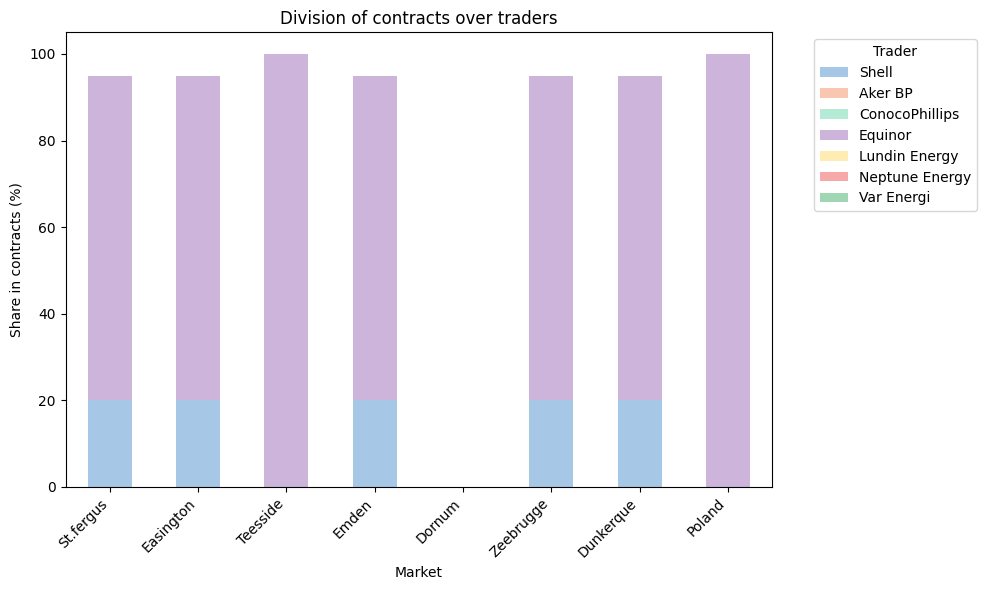

In [78]:
trader_percentages_df = pd.read_excel(file, sheet_name="TraderPercentages")

# Only select the relevent part of the dataframe
trader_percentages_df = trader_percentages_df.iloc[:7][trader_percentages_df.columns[:9]]
trader_percentages_df["Trader"] = trader_percentages_df["Trader"].apply(lambda x: get_short_name(x))
trader_percentages_df.set_index("Trader", inplace=True)
trader_percentages_df.columns = trader_percentages_df.columns.str.capitalize()
trader_percentages_df = trader_percentages_df * 100
trader_percentages_df = trader_percentages_df.T

# Plot stacked bar chart
trader_percentages_df.plot(kind="bar", stacked=True, color=bar_colors, figsize=(10, 6))

# Labels and title
plt.xlabel("Market")
plt.ylabel("Share in contracts (%)")
plt.title("Division of contracts over traders")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.tight_layout()
plt.savefig("Figures/minimum_contracts.pdf", bbox_inches='tight')
plt.show()

# Visualize facilities and pipes

In [79]:
arcs_df = pd.read_excel(file, sheet_name="Arcs")
arcs_df["geometry"] = arcs_df["geometry"].apply(wkt.loads)
arcs_geo_df = gpd.GeoDataFrame(arcs_df, geometry="geometry").set_crs(4326).to_crs(32631)

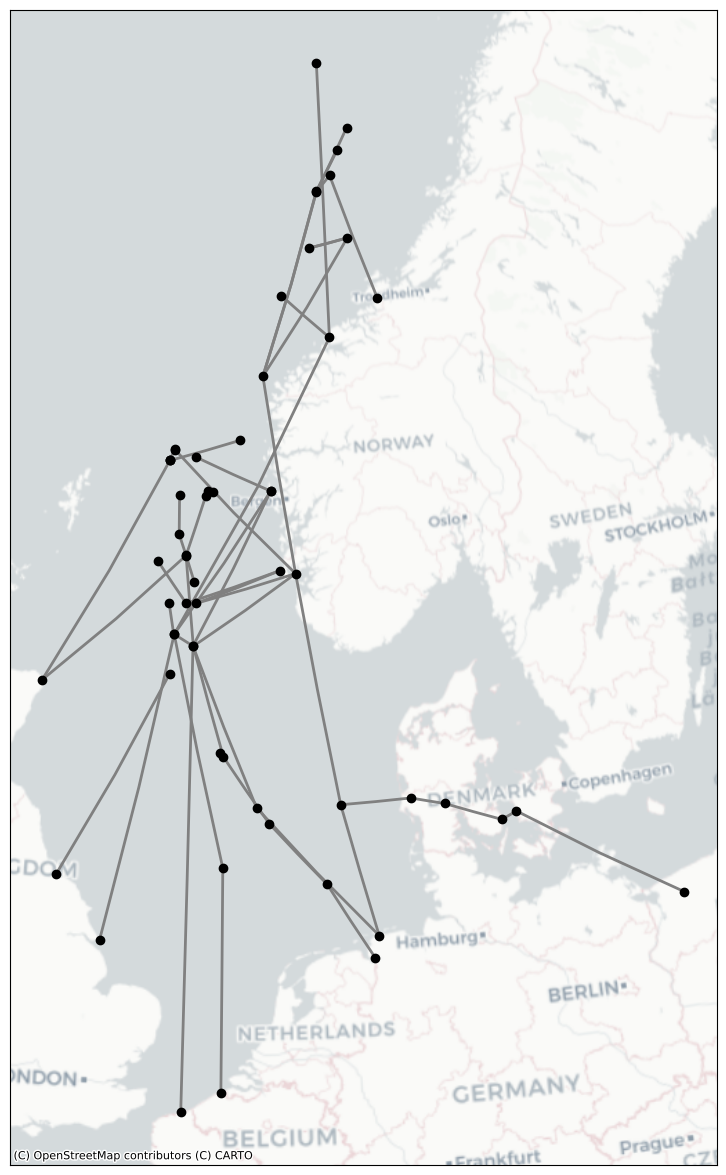

In [80]:
nodes_geo_df.plot(figsize=(10,15),zorder=2, color="black")
arcs_geo_df.plot(ax=plt.gca(), color='gray', linewidth=2, zorder=1)
cx.add_basemap(ax=plt.gca(), crs=32631, source=cx.providers.CartoDB.Positron)

plt.xticks([])
plt.yticks([])
plt.savefig("Figures/network.pdf", bbox_inches='tight')
plt.show()

# 4.3.1 Capacity booking in primary and secondary markets

In [81]:
def read_data(input_file):
    # Load the problem instance back from the file
    with open(f"{input_file}.pkl", "rb") as file:
        problem = pickle.load(file)

    # Read a dictionary from a json file
    solution = {}
    var_names = ["x_plus", "x_minus", "y_plus", "y_minus", "s_plus", "s_minus", "f", "q_sales", "q_production", "v", "w_plus", "w_minus"]

    # Helper variables
    traders_dict = {t.trader_id: get_short_name(t.name) for t in problem.traders}
    probabilities = {m.stage_id: m.probability for m in problem.stages}
    node_dict = {n.node_id: n.name.capitalize() for n in problem.stages[0].nodes}

    for var_name in var_names:
        df = pd.read_csv(f"{input_file}_{var_name}.csv", sep=";")

        if var_name.startswith("x") or var_name.startswith("y"):
            columns = ["Node", "Scenario node", "Trader", "Commodity"]
        elif var_name.startswith("s"):
            columns = ["Node", "Scenario node", "Commodity"]
        elif var_name.startswith("f"):
            columns = ["Trader", "Arc", "Scenario node", "Commodity"]
        elif var_name.startswith("q_s"):
            columns = ["Trader", "Node", "Scenario node", "Commodity", "Mix"]
        elif var_name.startswith("q_p"):
            columns = ["Trader", "Node", "Scenario node", "Commodity"]
        elif var_name.startswith("v") or var_name.startswith("w"):
            columns = ["Trader", "Node", "Scenario node", "Commodity"]

        df.columns = columns + ["Value"]

        df["Probability"] = df["Scenario node"].map(probabilities)

        df["Weighted value"] = df["Value"] * df["Probability"]

        df["Time block"] = (df["Scenario node"] - 1)% 4 + 1
        
        if "Trader" in df.columns:
            df["Trader"] = df["Trader"].map(traders_dict)

        if "Node" in df.columns:
            df["Node"] = df["Node"].map(node_dict)
        
        df["Stage"] = df["Scenario node"].apply(lambda x: 1 if x <= 4 else 2 if x <= 20 else 3)
        
        solution[var_name] = df

    return problem, solution

def get_value_from_solution(key, solution):
    return solution[key] if key in solution.keys() else 0

In [82]:
input_file = "Results/result_v2_A"

problem, solution = read_data(input_file)

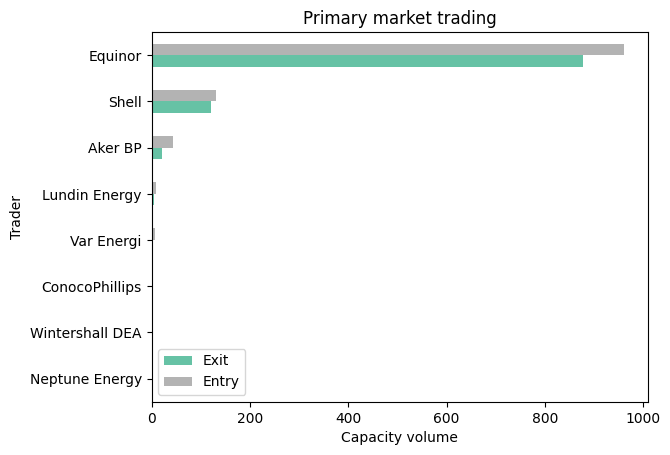

In [83]:
def primary_market(key, name):
    df = solution[key].copy()
    long_term_df = df[df["Stage"] == 1]

    grouped_df = long_term_df.groupby("Trader").sum()[["Value"]]
    grouped_df.columns = [name]

    return grouped_df

entry = primary_market("x_plus", "Entry")
exit = primary_market("x_minus", "Exit")

df = pd.concat([exit, entry], axis=1)

df.sort_values("Entry").plot(kind="barh", cmap="Set2")

plt.xlabel("Capacity volume")

plt.title("Primary market trading");

plt.savefig("Figures/primary_market.pdf", bbox_inches='tight')

Show for second and third stage per scenario who sells and buys how much exit capacity.
- We see that Equinor buys a lot of capacity, probably because it is the largest trader.

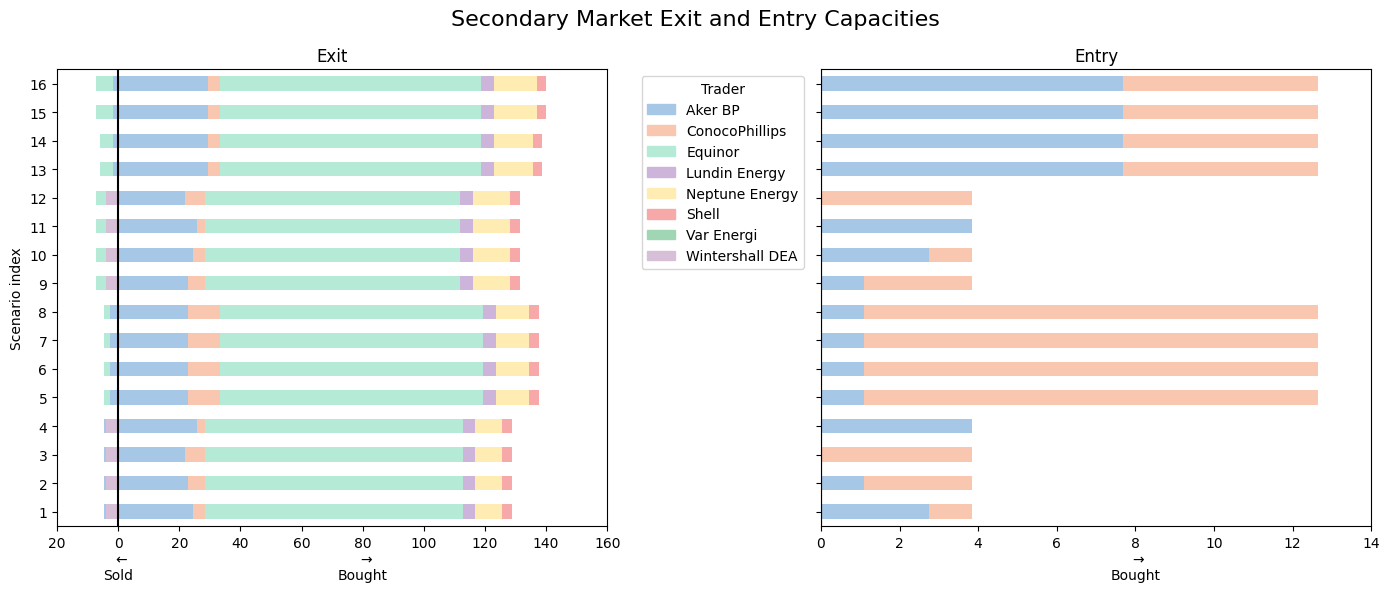

In [84]:
def secondary_market(key, name):
    df = solution[key].copy()

    # Drop first stage
    df = df[df["Stage"] > 1]
    
    # Add scenario indices
    df["Scenario index"] = np.where(
        df["Stage"] == 2,
        (df["Scenario node"] - 5) // 4 + 1,
        (df["Scenario node"] - 21) // 4 + 1
    )

    # Get the values for the second stage
    df_stage2 = df[df["Stage"] == 2]
    df_stage2 = df_stage2.groupby(["Scenario index", "Trader"]).sum()[["Value"]]

    # Get the values for the third stage
    df_stage3 = df[df["Stage"] == 3]
    df_stage3 = df_stage3.groupby(["Scenario index", "Trader"]).sum()[["Value"]]

    # Add a new column to identify which scenario from stage 2 belongs to stage 3.
    df_stage3["Group"] = [((idx[0] - 1) // 4 + 1, idx[1]) for idx in df_stage3.index]
    
    # Add the corresponding value from df_stage2
    df_stage3[name] = df_stage3["Value"] + df_stage3["Group"].map(df_stage2["Value"])
    
    return df_stage3[name].to_frame()


def plot_secondary_market(capacity_type, ax, show_legend=True):
    if capacity_type == "exit":
        key = "minus"
    else:
        key = "plus"
        
    entry_bought = secondary_market(f"x_{key}", "Bought")
    entry_sold = secondary_market(f"y_{key}", "Sold") * -1

    result = pd.concat([entry_bought, entry_sold], axis = 1)
    result = result[~(result.eq(0).all(axis=1))]
    
    result_pivot = result.reset_index().set_index("Scenario index").pivot(columns=["Trader"], values=["Bought", "Sold"]).fillna(0)
    result_pivot.sort_index(axis=1).plot(kind="barh", stacked=True, ax=ax, color=bar_colors)
    
    if show_legend:
        # Create legend handles (one per trader)
        legend_handles = [mpatches.Patch(color=colors_dict[trader], label=trader) for trader in traders]
        
        # Add legend only once
        ax.legend(handles=legend_handles, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend().set_visible(False)  # Hides the legend   

    ax.set_title(f"{capacity_type.capitalize()}")

    ax.axvline(x=0, color="black")

    # Get xtick positions and labels
    xticks = ax.get_xticks()
    xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
    
    # Add "Sold" and "Bought" once below the axis
    if any(tick < 0 for tick in xticks):
        negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
        middle_idx = negative_indices[len(negative_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
    if any(tick > 0 for tick in xticks):
        positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
        middle_idx = positive_indices[len(positive_indices) // 2]
        xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_ylabel("Scenario index")

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Two subplots side by side

# Plot both scenarios (exit and entry) on different subplots
plot_secondary_market("exit", axes[0], show_legend=True)  # First plot (exit)
plot_secondary_market("entry", axes[1], show_legend=False)  # Second plot (entry), no legend

# Add a global title for the whole figure
fig.suptitle("Secondary Market Exit and Entry Capacities", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.savefig("Figures/secondary_zoom1_market.pdf", bbox_inches='tight')


Let's zoom in on the results for one specific scenario!
- We see that equinor buys a lot of capacity.
- Poland ... *Even overleggen!*
- Emden is not included in the first 4 scenarios. *Even overleggen!*

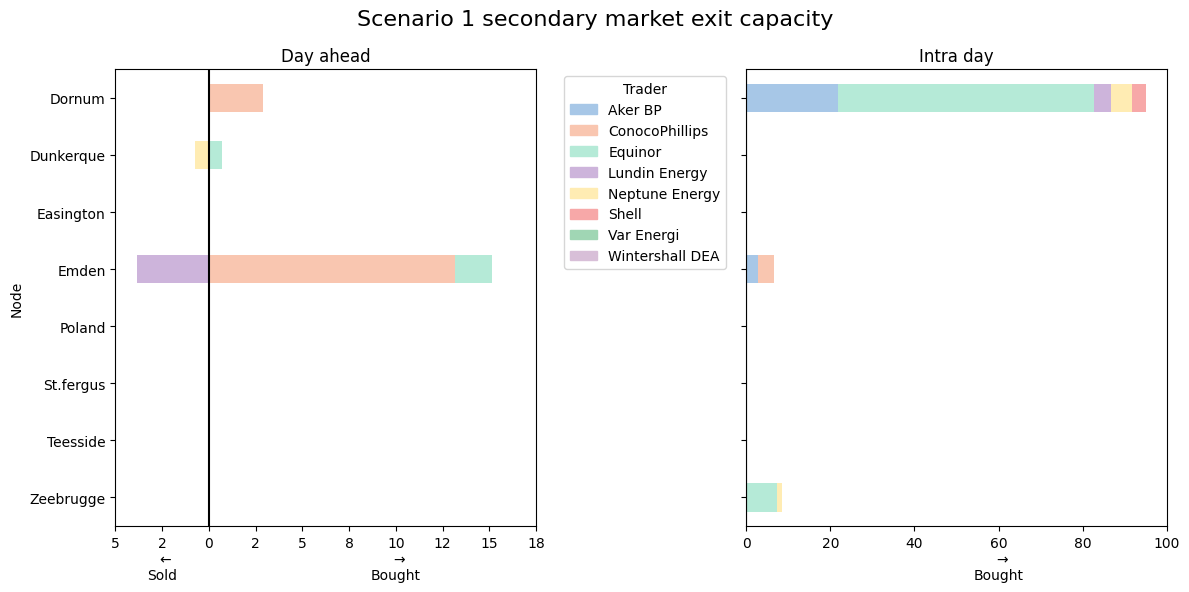

In [85]:
def secondary_market_specific(key, name, stage):
    df = solution[key].copy()

    # Drop the first stage
    df = df[df["Stage"] > 1]
    
    # Add scenarios
    df["Scenario index"] = np.where(
        df["Stage"] == 2,
        (df["Scenario node"] - 5) // 4 + 1,
        (df["Scenario node"] - 21) // 4 + 1
    )

    # Select the stage we're interested in
    df_stage = df[df["Stage"] == stage]
    df_stage = df_stage.groupby(["Scenario index", "Trader", "Node"]).sum()[["Value"]]

    df_stage.columns = [name]

    return df_stage

def plot_specific(capacity_type, scenario_idx):
    if capacity_type == "exit":
        key = "minus"
    else:
        key = "plus"
        
    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Two subplots side by side
    fig.suptitle(f"Scenario {scenario_idx} secondary market {capacity_type} capacity", fontsize=16)

    # Map scenario idx 3 to scenario idx 2
    scenario_idx2 = (scenario_idx - 1) // 4 + 1
    
    for i, stage in enumerate([2, 3]):
        if stage == 2:
            s = scenario_idx2
        else:
            s = scenario_idx
        bought = secondary_market_specific(f"x_{key}", "Bought", stage).loc[s,:]
        sold = secondary_market_specific(f"y_{key}", "Sold", stage).loc[s,:] * -1

        result = pd.concat([bought, sold], axis = 1)
        result = result[~(result.eq(0).all(axis=1))]
        
        result_pivot = result.reset_index().set_index("Node").pivot(columns=["Trader"], values=["Bought", "Sold"]).fillna(0)
        result_pivot = result_pivot.reindex(index=markets, fill_value=0).sort_index(ascending=False)
        
        result_pivot.plot(kind="barh", stacked=True, ax=axes[i], color=bar_colors)

        axes[i].axvline(x=0, color="black")

        axes[i].set_ylabel("Node")

        if stage == 2:
            stage_name = "Day ahead"
        else:
            stage_name = "Intra day"
            
        axes[i].set_title(f"{stage_name}")

        # Get xtick positions and labels
        xticks = axes[i].get_xticks()
        xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]
        
        # Add "Sold" and "Bought" labels
        if any(tick < 0 for tick in xticks):
            negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
            middle_idx = negative_indices[len(negative_indices) // 2]
            xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
        if any(tick > 0 for tick in xticks):
            positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
            middle_idx = positive_indices[len(positive_indices) // 2]
            xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"
        
        axes[i].set_xticks(xticks)
        axes[i].set_xticklabels(xtick_labels)
              
        if i == 0:
            # Create legend handles (one per trader)
            legend_handles = [mpatches.Patch(color=colors_dict[trader], label=trader) for trader in traders]
            
            # Add legend only once
            axes[i].legend(handles=legend_handles, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
        else:
            axes[i].legend().set_visible(False)  # Hide legend for second plot

plot_specific("exit", 1)
plt.tight_layout()

plt.savefig("Figures/secondary_zoom2_market.pdf", bbox_inches='tight')

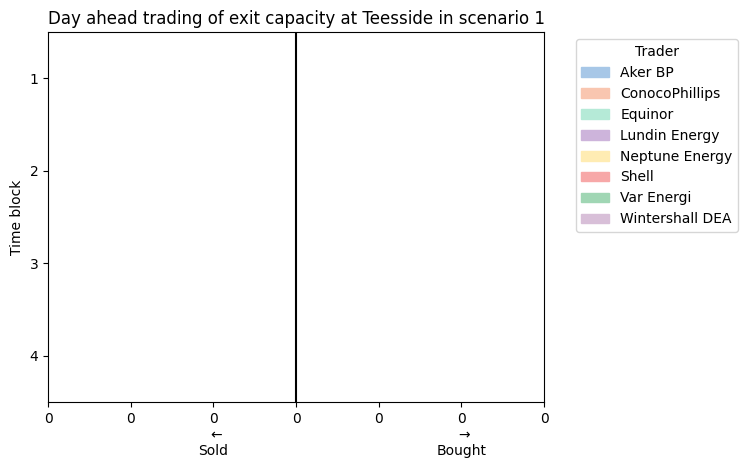

In [86]:
bought = solution["x_minus"]
sold = solution["y_minus"]
for i, df in enumerate([bought, sold]):
    df = df[(df["Stage"] == 2) & (df["Node"] == "Teesside") & (df["Scenario node"] <= 8)]
    df = df.reset_index().set_index(["Time block"]).pivot(columns="Trader", values="Value")
    if i == 1:
        df = df * -1
    df.sort_index(ascending=False).plot(kind="barh", stacked=True, ax=plt.gca(), color=bar_colors)

plt.axvline(x=0, color="black")

ax = plt.gca()

# Get xtick positions and labels
xticks = ax.get_xticks()
xtick_labels = [f"{abs(tick):.0f}" for tick in xticks]

# Add "Sold" and "Bought" labels
if any(tick < 0 for tick in xticks):
    negative_indices = [idx for idx, tick in enumerate(xticks) if tick <= 0]
    middle_idx = negative_indices[len(negative_indices) // 2]
    xtick_labels[middle_idx] += "\n " + r"$\leftarrow$" + "\n" + "Sold"
if any(tick > 0 for tick in xticks):
    positive_indices = [idx for idx, tick in enumerate(xticks) if tick >= 0]
    middle_idx = positive_indices[len(positive_indices) // 2]
    xtick_labels[middle_idx] += "\n " + r"$\rightarrow$" + "\n" + "Bought"

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Create legend handles (one per trader)
legend_handles = [mpatches.Patch(color=colors_dict[trader], label=trader) for trader in traders]

# Add legend only once
plt.legend(handles=legend_handles, title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.ylabel("Time block");
plt.title("Day ahead trading of exit capacity at Teesside in scenario 1");

plt.savefig("Figures/secondary_zoom3_market.pdf", bbox_inches='tight')


Show TSO sales!
- TSO sells more entry than exit capacity in the first stage as we're going to produce anyway, but we, due to market uncertainty, do not know where we're selling it. As this is complex, in the third stage, relatively a lot of exit capacity is sold. 

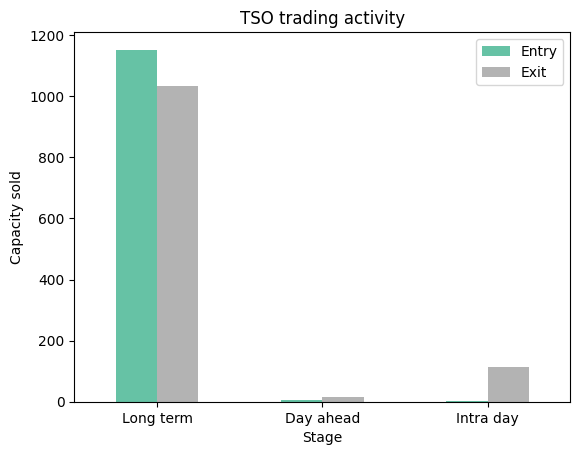

In [87]:
entry = solution["s_plus"].groupby(["Stage"]).sum()[["Weighted value"]]
entry.columns = ["Entry"]
exit = solution["s_minus"].groupby(["Stage"]).sum()[["Weighted value"]]
exit.columns = ["Exit"]

result = pd.concat([entry, exit], axis = 1)
result.plot(kind="bar", cmap="Set2")

plt.title("TSO trading activity")
plt.ylabel("Capacity sold")

plt.xticks([0, 1, 2], ["Long term", "Day ahead", "Intra day"], rotation=0);

plt.savefig("Figures/TSO_trading.pdf", bbox_inches='tight')

# 4.3.2 System throughput

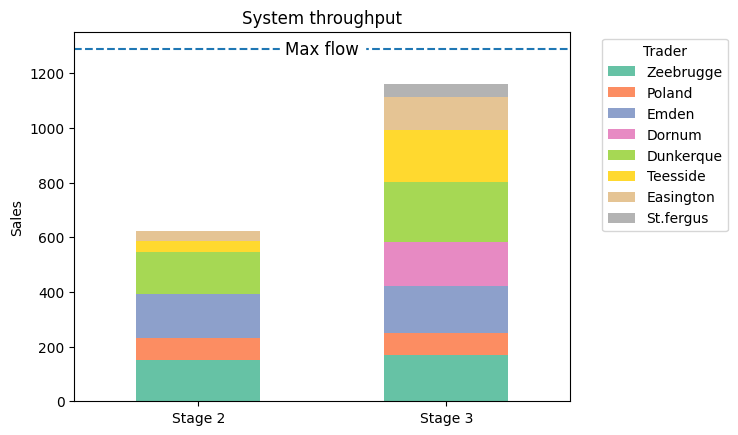

In [88]:
q_sales = solution["q_sales"]
result = pd.DataFrame()
for stage in [2, 3]:
    df = q_sales[q_sales["Stage"] == stage].groupby("Node").sum()["Weighted value"].loc[markets].reindex(markets).fillna(0).to_frame()
    df.columns = [f"Stage {stage}"]
    result = pd.concat([result, df], axis=1)

result.T.plot(kind="bar", stacked=True, cmap="Set2")

max_flow = 322*4
plt.axhline(y=max_flow, linestyle="--")
plt.text(0.5, max_flow, 'Max flow', fontsize=12, va='center', ha='center', backgroundcolor='w')

plt.xticks(rotation=0)

plt.legend(title="Trader", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("Sales")

plt.title("System throughput")

plt.savefig("Figures/system_throughput.pdf", bbox_inches='tight')


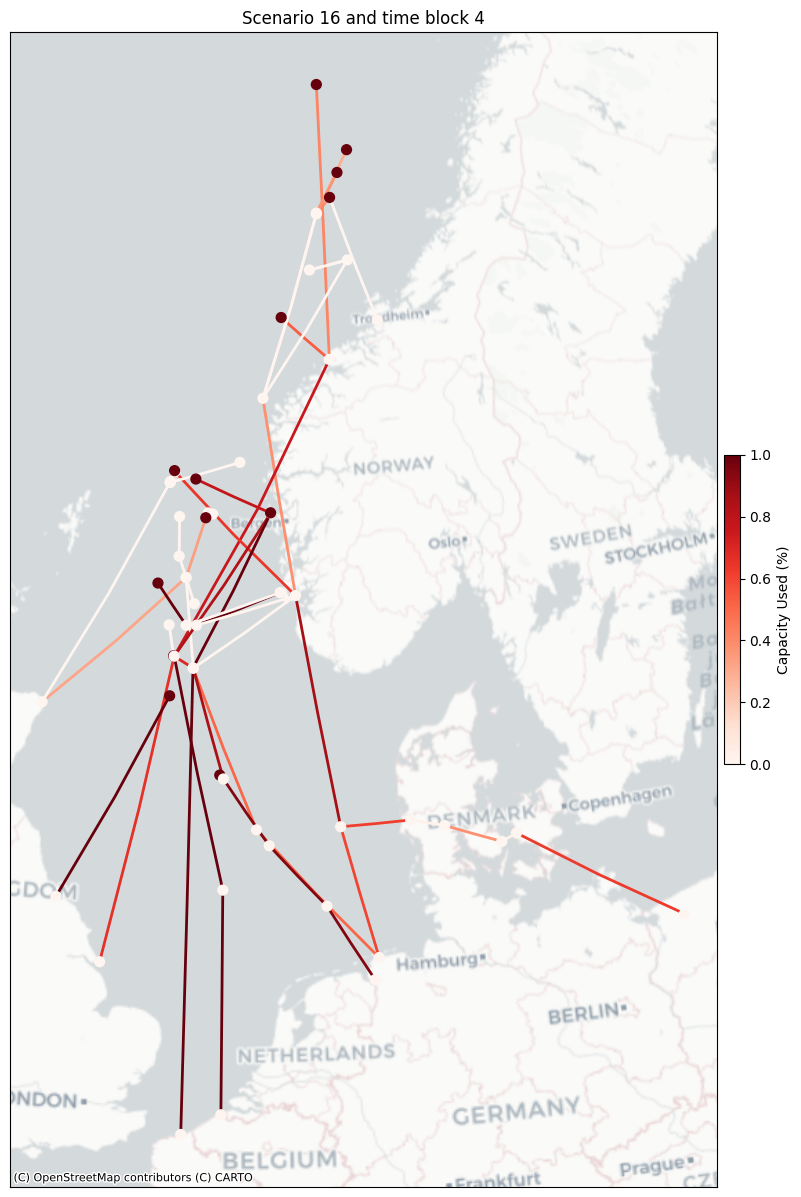

In [89]:
scenario_idx = 84

production = solution["q_production"]
production = production[production["Scenario node"] == scenario_idx].groupby("Node").sum()["Value"].to_frame()

nodes_geo_df["Name"] = nodes_geo_df["Name"].str.capitalize()
production_nodes_df = nodes_geo_df.merge(production, left_on="Name", right_on=production.index)
production_nodes_df["Capacity used (%)"] = production_nodes_df["Value"] / production_nodes_df["Production Capacity Gas"]
production_nodes_df["Capacity used (%)"] = production_nodes_df["Capacity used (%)"].fillna(0)

flow = solution["f"]
flow = flow[flow["Scenario node"] == scenario_idx].groupby("Arc").sum()["Value"].to_frame()

arcs_flow_df = arcs_geo_df.merge(flow, left_on="ID", right_on=flow.index)
arcs_flow_df["Capacity used (%)"] = arcs_flow_df["Value"] / arcs_flow_df["Capacity"]

# Normalize capacity used for colormap
norm = Normalize(vmin=arcs_flow_df["Capacity used (%)"].min(), vmax=arcs_flow_df["Capacity used (%)"].max())
cmap = cm.Reds  # Choose a colormap (can be 'coolwarm', 'plasma', etc.)
colors = [cmap(norm(val)) for val in arcs_flow_df["Capacity used (%)"]]

# Prepare lines for LineCollection
lines = [list(geom.coords) for geom in arcs_flow_df.geometry]  # Convert geometries to coordinate pairs

# Plot
fig, ax = plt.subplots(figsize=(10, 15))

# Normalize capacity used for colormap
norm_nodes = Normalize(vmin=production_nodes_df["Capacity used (%)"].min(), 
                       vmax=production_nodes_df["Capacity used (%)"].max())
cmap_nodes = cm.Reds  # Choose colormap

# Assign colors based on capacity used
node_colors = [cmap_nodes(norm_nodes(val)) for val in production_nodes_df["Capacity used (%)"]]

# Plot nodes with color mapping
production_nodes_df.plot(ax=ax, zorder=3, color=node_colors, markersize=50)

# Plot arcs using LineCollection
lc = LineCollection(lines, colors=colors, linewidths=2, zorder=1)
ax.add_collection(lc)

# Add basemap
cx.add_basemap(ax, crs=32631, source=cx.providers.CartoDB.Positron)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.01)
cbar.set_label("Capacity Used (%)")

plt.title(f"Scenario {(scenario_idx - 21) // 4 + 1} and time block {(scenario_idx - 1) % 4 + 1}")

plt.savefig("Figures/capacity_visualized.pdf", bbox_inches='tight')

# 4.3.3 Use of storage

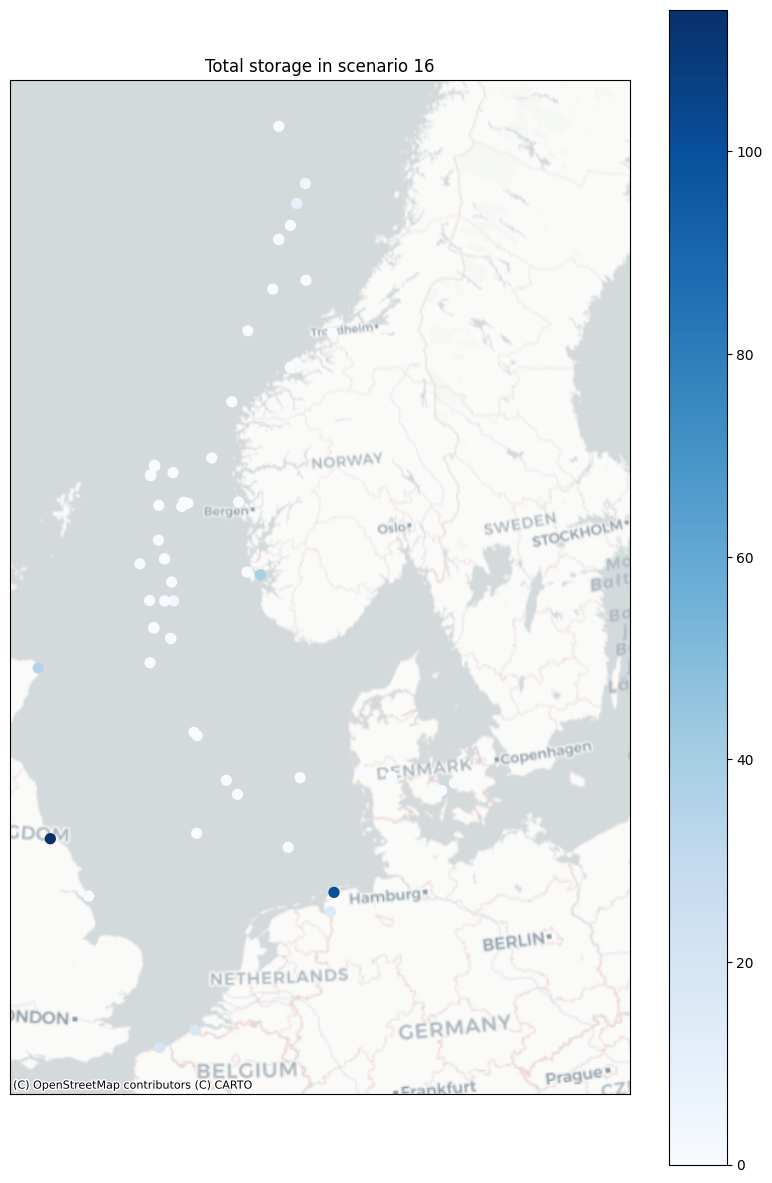

In [90]:
storage = solution["v"]

storage = storage[storage["Stage"] == 3]

# Add scenario indices
storage["Scenario index"] = np.where(
        storage["Stage"] == 2,
        (storage["Scenario node"] - 5) // 4 + 1,
        (storage["Scenario node"] - 21) // 4 + 1
)

scenario_idx = 16

storage = storage[storage["Scenario index"] == scenario_idx].groupby("Node").sum()["Value"].to_frame()
storage.columns = ["Storage"]

production_nodes_df = nodes_geo_df.merge(storage, left_on="Name", right_on=production.index)

# Normalize capacity used for colormap
norm_nodes = Normalize(vmin=production_nodes_df["Storage"].min(), 
                       vmax=production_nodes_df["Storage"].max())
cmap_nodes = cm.Blues  # Choose colormap

# Assign colors based on capacity used
node_colors = [cmap_nodes(norm_nodes(val)) for val in production_nodes_df["Storage"]]

# Plot
fig, ax = plt.subplots(figsize=(10, 15))

# Plot nodes with color mapping
production_nodes_df.plot(ax=ax, zorder=3, color=node_colors, markersize=50)
    
production_nodes_df.plot(ax=ax, column="Storage", cmap='Blues',legend=True)

# Add basemap
cx.add_basemap(ax, crs=32631, source=cx.providers.CartoDB.Positron)

plt.xticks([])
plt.yticks([])

plt.title(f"Total storage in scenario {scenario_idx}")

plt.savefig("Figures/storage_visualized.pdf", bbox_inches='tight')


# 4.3.4 Profitability

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_1099/1525678538.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scenario index"] = np.where(
/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_1099/1525678538.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scenario index"] = np.where(
/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_1099/1525678538.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

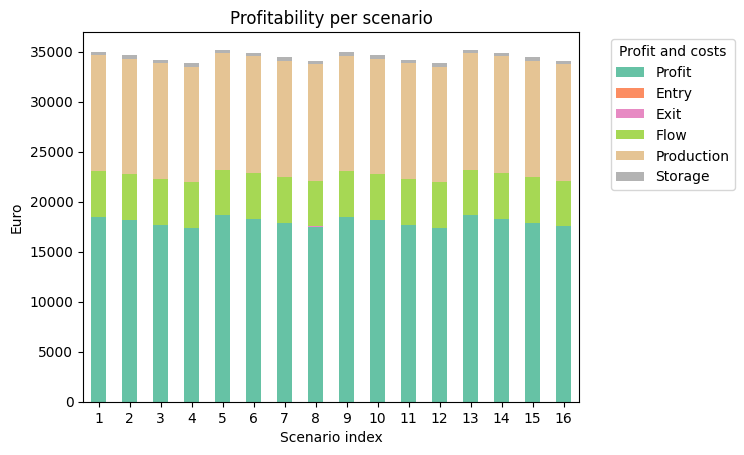

In [99]:
def get_objective(solution, trader = None):
    x_plus = solution["x_plus"].copy()
    y_plus = solution["y_plus"].copy()
    
    x_minus = solution["x_minus"].copy()
    y_minus = solution["y_minus"].copy()
    
    flow = solution["f"].copy()
    q_production = solution["q_production"].copy()
    storage = solution["w_plus"].copy()
    q_sales = solution["q_sales"].copy()

    if trader:
        for dummy in [x_plus, y_plus, x_minus, y_minus, flow, q_production, storage, q_sales]:
            dummy.drop(dummy.loc[dummy["Trader"] != trader].index, inplace=True)
    
    first_stage_entry_exit = 5
    second_stage_entry_exit = 5.2
    third_stage_entry_exit = 5.4
    production_costs = 10
    storage_costs = 3
    flow_costs = 1
    
    resulting_df = pd.DataFrame()
    for name, df in zip(["Entry bought", "Entry sold", "Exit bought", "Exit sold"], [x_plus, y_plus, x_minus, y_minus]):
        df["Cost parameter"] = np.where(
            df["Stage"] == 1, first_stage_entry_exit,
            np.where(df["Stage"] == 2, second_stage_entry_exit, third_stage_entry_exit)
        )
            
        # Drop first stage
        df = df[df["Stage"] > 1]
        
        # Add scenario indices
        df["Scenario index"] = np.where(
            df["Stage"] == 2,
            (df["Scenario node"] - 5) // 4 + 1,
            (df["Scenario node"] - 21) // 4 + 1
        )
        
        df = df.assign(Costs=df["Value"] * df["Cost parameter"])
        
        # Get the values for the second stage
        df_stage2 = df[df["Stage"] == 2]
        df_stage2 = df_stage2.groupby(["Scenario index"]).sum()[["Costs"]]
        
        # Get the values for the third stage
        df_stage3 = df[df["Stage"] == 3]
        df_stage3 = df_stage3.groupby(["Scenario index"]).sum()[["Costs"]]
        
        # Add a new column to identify which scenario from stage 2 belongs to stage 3.
        df_stage3["Group"] = [(idx - 1) // 4 + 1 for idx in df_stage3.index]
        
        # Add the corresponding value from df_stage2
        df_stage3[name] = df_stage3["Costs"] + df_stage3["Group"].map(df_stage2["Costs"])
            
        resulting_df = pd.concat([resulting_df, df_stage3[[name]]], axis=1)
    
    for name, df, costs in zip(["Flow", "Production", "Storage"], [flow, q_production, storage], [flow_costs, production_costs, storage_costs]):
        df = df[df["Stage"] == 3]
        df["Scenario index"] = (df["Scenario node"] - 21) // 4 + 1
        df["Cost parameter"] = costs
        df[name] = df["Value"] * df["Cost parameter"]
        
        df = df.groupby("Scenario index").sum()[[name]]
        resulting_df = pd.concat([resulting_df, df[[name]]], axis=1)
    
    sales_prices = {m.stage_id: {n.name.capitalize(): max(n.sales_prices.values()) for n in m.nodes} for m in problem.stages}
    
    q_sales = q_sales[q_sales["Stage"] == 3]
    q_sales["Scenario index"] = (q_sales["Scenario node"] - 21) // 4 + 1
    q_sales["Price"] = q_sales.apply(lambda x: sales_prices[x["Scenario node"]][x["Node"]], axis=1)
    q_sales["Revenue"] = q_sales["Price"] * q_sales["Value"]
    q_sales = q_sales.groupby("Scenario index").sum()[["Revenue"]]
    
    resulting_df = pd.concat([resulting_df, q_sales[["Revenue"]]], axis=1)
    
    resulting_df["Entry"] = resulting_df["Entry bought"] - resulting_df["Entry sold"] 
    resulting_df["Exit"] = resulting_df["Exit bought"] - resulting_df["Exit sold"] 
    resulting_df["Profit"] = resulting_df["Revenue"] - resulting_df[["Entry", "Exit", "Flow", "Production", "Storage"]].sum(axis=1)

    return resulting_df 

resulting_df = get_objective(solution)

resulting_df[["Profit", "Entry", "Exit", "Flow", "Production", "Storage"]].plot(kind="bar", stacked=True, cmap="Set2")

plt.legend(title="Profit and costs", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks(rotation=0)
plt.ylabel("Euro")
plt.xlabel("Scenario index")
plt.title("Profitability per scenario")

plt.savefig("Figures/profitability_per_scenario.pdf", bbox_inches='tight')

/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_1099/1518066938.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scenario index"] = np.where(
/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_1099/1518066938.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scenario index"] = np.where(
/var/folders/fw/zjz8sscn11z9hzvyq33zv4xh0000gn/T/ipykernel_1099/1518066938.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

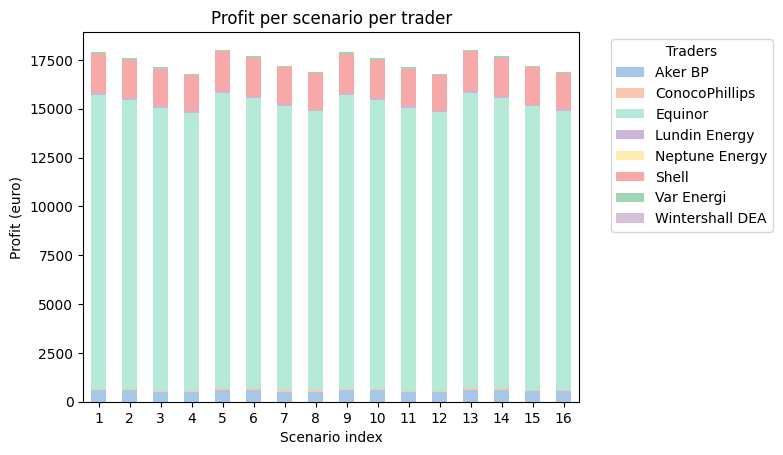

In [92]:
results = pd.DataFrame()
for trader in traders:
    df = get_objective(solution, trader=trader)[["Profit"]]
    df.columns = [trader]
    results = pd.concat([results, df], axis=1)

results.plot(kind="bar", stacked=True, color=bar_colors);

plt.ylabel("Profit (euro)")

plt.xticks(rotation=0);

plt.legend(title="Traders", bbox_to_anchor=(1.05, 1), loc="upper left");

plt.title("Profit per scenario per trader")

plt.savefig("Figures/profit_per_trader.pdf", bbox_inches='tight')


# 4.3.5 Sensitivity for utilisation rates

In [93]:
result = []

for beta in [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 1]:
    input_file = f"Results/result_F{beta}"
    
    problem, solution = read_data(input_file)

    df = get_objective(solution)

    result.append(df["Profit"].sum())

plt.plot(result.keys(), result.values(), "o-");

plt.xlabel(r"$\beta$");
plt.ylabel("Profit (€)");

plt.title("Sensitivity to utilisation rates");

plt.savefig("Figures/sensitivity_utilisation_rates.pdf", bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: 'Results/result_F0_x_plus.csv'

In [ ]:
key = "x_plus"
df = solution[key].copy()
long_term_df = df[df["Stage"] == 1]

long_term_df[(long_term_df["Trader"].str.startswith("Winter")) & long_term_df["Value"] > 0]

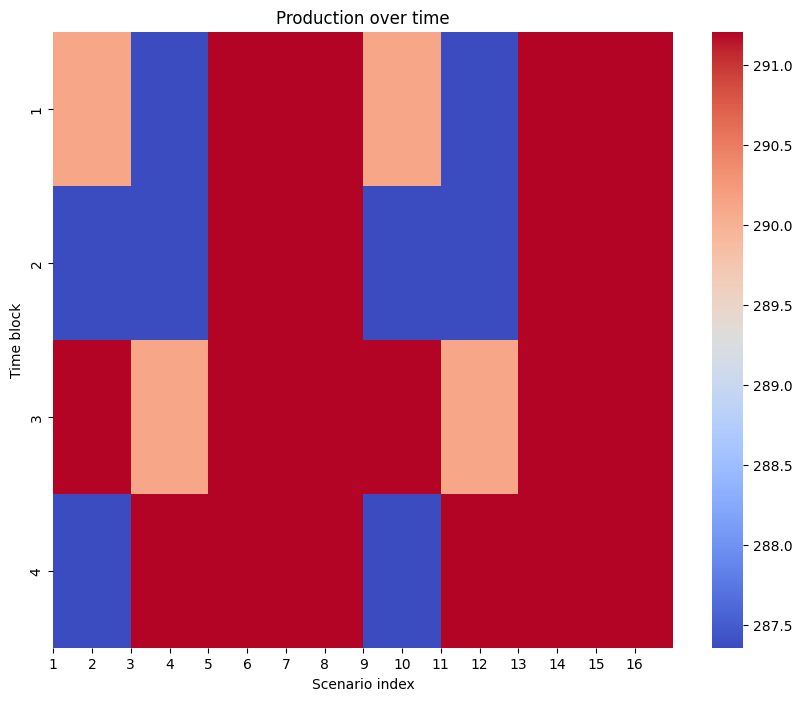

In [94]:
q_production = solution["q_production"].copy()
q_production["Scenario index"] = (q_production["Scenario node"] - 21) // 4 + 1

q_production = q_production.groupby(["Scenario index", "Time block"]).sum()[["Value"]].reset_index()
q_production = q_production.pivot(index="Time block", columns=["Scenario index"], values=["Value"])

plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(q_production, annot=False, cmap="coolwarm", linewidths=0)
plt.title("Production over time")
plt.xlabel("Scenario index")
plt.xticks(list(range(16)), list(range(1, 17)), rotation=0)
plt.show()


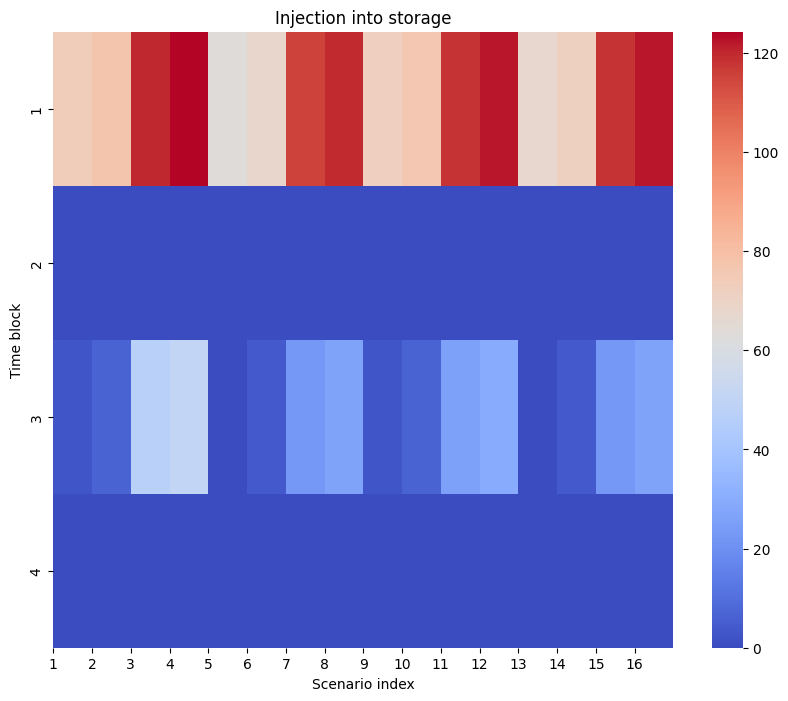

In [95]:
w_plus = solution["w_plus"].copy()
w_plus["Scenario index"] = (w_plus["Scenario node"] - 21) // 4 + 1

w_plus = w_plus.groupby(["Scenario index", "Time block"]).sum()[["Value"]].reset_index()
w_plus = w_plus.pivot(index="Time block", columns=["Scenario index"], values=["Value"])

plt.figure(figsize=(10, 8))  # Adjust figure size
sns.heatmap(w_plus, annot=False, cmap="coolwarm", linewidths=0)
plt.title("Injection into storage")
plt.xlabel("Scenario index")
plt.xticks(list(range(16)), list(range(1, 17)), rotation=0)
plt.show()


In [106]:
input_files = ["Results/result_v2_A", "Results/result_v2_A_conservative"]

for label, input_file in zip(["Flexible", "Conservative"], input_files):
    problem, solution = read_data(input_file)

    print(f"{label} model")

    objective = get_objective(solution).sum()["Profit"]
    print(f"Total profit {objective:.2f}")
    
    storage = solution["v"].copy()
    
    print(f"Total storage {storage['Weighted value'].sum():.2f}\n")

Flexible model
Total profit 278461.27
Total storage 301.01

Conservative model
Total profit 287849.74
Total storage 996.19

